In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1


# Demonstrating Metrics of Cognitive Diversity on hand of Amartya Sen's famous Flute Parable

This notebook investigates the usefulness and meaning of diversity metrics meant to measure the diversity of philosophical arguments on hand of a parable introduced by the economist and philosopher **Amartya Sen** in his book *The Idea of Justice* (2009). The parable demonstrates that different ethical principles, each logical and reasonable in their own right, can lead to mutually conflicting and disparate conclusions about justice.

In the parable, three children—Anne, Bob, and Carla—dispute the ownership of a flute. Each child offers a distinct argument grounded in a specific ethical framework:
- **Anne (Utilitarian):** She argues that she is the only one who can play the flute, and therefore, it should go to her as the most utilitarian choice.
- **Bob (Egalitarian):** He claims the flute based on his disadvantaged position, as he has no toys.
- **Carla (Libertarian):** She asserts ownership because she made the flute with her own effort and resources.

While Sen uses this example to illustrate how justice can be interpreted differently based on the underlying ethical framework, this notebook uses the parable to demonstrate metrics for assessing the **diversity of philosophical arguments**. Specifically, we explore how semantic diversity can be quantified and compared across different combinations of arguments using modern natural language processing techniques.

For more information on Amartya Sen’s parable and his philosophical contributions, refer to the [Wikipedia article on *The Idea of Justice*]( https://en.wikipedia.org/wiki/The_Idea_of_Justice ).

---

### Reference
Sen, A. (2009). *The Idea of Justice*. Cambridge, MA: Harvard University Press.


## Step 1: Defining and Calculating Diversity

### Diversity Measure: Mathematical Formulation and Interpretation

The diversity measure implemented in this notebook is rooted in **information theory**, leveraging the **Jensen-Shannon Divergence (JSD)**, a symmetrized and bounded version of the Kullback-Leibler Divergence (KL Divergence). Below, we outline the exact mathematical formulation, interpret its meaning when applied to probability distributions, and discuss how it translates to semantic embeddings.

---

### Mathematical Formulation

#### **Step 1: Jensen-Shannon Divergence**
Given a set of \( n \) distributions \( \{P_1, P_2, \dots, P_n\} \), the **Jensen-Shannon Divergence** (JSD) for this set is computed as follows:

1. **Step 1.1: Average Distribution**  
   Compute the average distribution \( M \) as:
   $$
   M = \frac{1}{n} \sum_{i=1}^{n} P_i
   $$
   where \( P_i \) is the \( i \)-th distribution.

2. **Step 1.2: KL Divergence for Each Distribution**  
   Compute the Kullback-Leibler Divergence of each \( P_i \) with respect to \( M \):
   $$
   D_{KL}(P_i \parallel M) = \sum_{x} P_i(x) \log \frac{P_i(x)}{M(x)}
   $$

3. **Step 1.3: Jensen-Shannon Divergence**  
   The JSD is then the average of these KL divergences:
   $$
   JSD = \frac{1}{n} \sum_{i=1}^{n} D_{KL}(P_i \parallel M)
   $$

---

#### **Step 2: Diversity Metric**
The diversity measure normalizes the JSD and scales it to a range between 0 and 1:

1. The maximum possible JSD for \( n \) distributions is given by:

$$
\text{max_JSD} = \log_2(n)
$$

   This maximum occurs when all \( n \) distributions are orthogonal (i.e., completely disjoint).

2. Normalize the JSD:
   $$
   \text{Normalized JSD} = \frac{JSD}{\text{max_JSD}}
   $$

3. Compute the final diversity measure as:
   $$
   \text{Diversity} = \sqrt{\text{Normalized JSD}}
   $$

---

### Information-Theoretic Interpretation

#### **When the Elements Are Probability Distributions**
In the traditional context where the elements are **discrete probability distributions**, the diversity measure quantifies the extent to which these distributions differ from one another:
- **Low Diversity (\( \approx 0 \))**:
  - Indicates that all the distributions are nearly identical.
  - The JSD is close to 0 because the KL divergence for each distribution relative to the average distribution is small.
- **High Diversity (\( \approx 1 \))**:
  - Indicates that the distributions are maximally disjoint (orthogonal).
  - The JSD reaches its maximum value, reflecting that the distributions share no common support.

#### **When the Elements Are Semantic Embeddings**
When applied to **semantic embeddings** (as in our case), the diversity measure retains a similar interpretation but within the context of **semantic similarity**:
1. Each embedding is treated as a high-dimensional distribution by normalizing it to sum to 1. While not strictly a probability distribution in the conventional sense, this normalization allows us to use the JSD framework to compare the "spread" or "overlap" of the embeddings.
2. **Semantic Diversity**:
   - **Low Diversity:** Indicates that the embeddings are semantically similar, sharing overlapping meaning.
   - **High Diversity:** Indicates that the embeddings represent semantically distinct or orthogonal ideas.

---

### Visual Plots and Their Interpretation

The histograms of diversity scores across different sampling strategies (e.g., AAA, ABC) reinforce this interpretation:
1. **AAA (Single Column)**:
   - Low diversity scores indicate that arguments within a single perspective are semantically close, as expected.
2. **ABC (One from Each Column)**:
   - Higher diversity scores reflect the inclusion of semantically distinct arguments from different perspectives (Anne, Bob, Carla).
3. **Mixed Groups (e.g., AAB, ABB)**:
   - Diversity scores fall between the extremes, reflecting the partial inclusion of distinct perspectives.

---

### Applying Information-Theoretic Metrics to Semantic Embeddings

#### **The Connection to Information Theory**
The use of information-theoretic metrics like JSD in semantic contexts relies on the premise that **semantic distance** in a high-dimensional space mirrors the statistical properties of true distributions. While embeddings are not discrete probability distributions, their normalized form allows us to leverage these metrics effectively.

#### **Challenges and Limitations**
1. **Interpretational Leap**:
   - While the diversity measure captures semantic differences, it does not inherently reflect philosophical validity or soundness.
2. **Embedding Quality**:
   - The measure's accuracy depends on the embedding model's ability to represent semantic relationships faithfully.

#### **Strengths**
1. **Universality**:
   - The diversity metric provides a quantitative framework to compare semantic similarity across arguments, even if they are abstract or complex.
2. **Intuition Preservation**:
   - The measure's interpretation aligns well with intuition, as seen in the plots, where sampling strategies involving multiple perspectives yield higher diversity.

---

This discussion provides the mathematical foundation and theoretical reasoning behind the diversity measure, as well as its interpretation in both traditional and semantic contexts. It sets the stage for applying these metrics to philosophical arguments in the remainder of the notebook.



In [ ]:
# Required Imports
import numpy as np
import pandas as pd
from scipy.stats import entropy
import random
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

def js_divergence(distributions):
    """
    Compute the N-point Jensen-Shannon divergence for a list of distributions.
    """
    n = len(distributions)
    distributions = np.array(distributions, dtype=np.float64)

    # Check for identical distributions
    if np.allclose(distributions, distributions[0]):
        return 0.0  # JSD is 0 for identical distributions

    # Ensure non-negativity by shifting using the global minimum
    global_min = np.min(distributions)  # Global minimum
    distributions = distributions - global_min  # Shift by global minimum

    # Normalize each distribution
    row_sums = distributions.sum(axis=1, keepdims=True)
    distributions = np.divide(distributions, row_sums, out=np.zeros_like(distributions), where=row_sums != 0)

    # Replace any all-zero distributions with a uniform distribution
    all_zero_rows = (row_sums == 0).flatten()
    if np.any(all_zero_rows):
        uniform_dist = np.ones(distributions.shape[1]) / distributions.shape[1]
        distributions[all_zero_rows] = uniform_dist

    # Compute the average distribution
    avg_distribution = np.mean(distributions, axis=0)
    avg_distribution /= avg_distribution.sum()  # Normalize

    # Compute JSD: divergence of each distribution from the average
    jsd = sum(entropy(dist, avg_distribution, base=2) for dist in distributions) / n
    return jsd

def diversity(distributions):
    """
    Compute the diversity metric based on the N-point JSD.
    Normalizes the result to ensure values between 0 and 1.
    """
    n = len(distributions)
    jsd_n = js_divergence(distributions)
    max_jsd = np.log2(n)  # Theoretical maximum JSD value for N distributions
    normalized_jsd = jsd_n / max_jsd if max_jsd > 0 else 0.0
    return np.sqrt(normalized_jsd)

# Test predefined distributions
# Fix dist_uniform to match the expected dimensionality (3 elements)
dist_uniform = [1/3, 1/3, 1/3]  # Uniform distribution with 3 elements
dist_contrast = [1, 0, 0]
dist3 = [0.2, 0.7, 0.1]

print("Testing predefined distributions:")
examples = [
    ([dist_uniform, dist_uniform], "Identical distributions (should be 0)"),
    ([dist_contrast, [0, 1, 0], [0, 0, 1]], "Completely different distributions (should be 1)"),
    ([dist_uniform, dist_contrast, dist3], "Intermediate case")
]

for distributions, desc in examples:
    div_value = diversity(distributions)
    print(f"Diversity for {desc}: {div_value:.5f}")


# Test embeddings from Sentence Transformer
print("\nTesting embeddings from Sentence Transformer:")
sentences = [
    "Artificial intelligence is changing the world.",
    "Machine learning enables computers to learn from data.",
    "Deep learning is a subset of machine learning.",
    "I enjoy hiking in the mountains."
]
# Load the Sentence Transformer model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

embeddings = model.encode(sentences)

# Ensure embeddings are valid probability distributions
embeddings = np.maximum(embeddings, 0)
row_sums = embeddings.sum(axis=1, keepdims=True)
embeddings = np.divide(embeddings, row_sums, out=np.zeros_like(embeddings), where=row_sums != 0)

# Calculate diversity of the embeddings
embedding_diversity = diversity(embeddings)
print(f"Diversity of Semantic Embeddings: {embedding_diversity:.5f}")


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Testing predefined distributions:
Diversity for Identical distributions (should be 0): 0.00000
Diversity for Completely different distributions (should be 1): 1.00000
Diversity for Intermediate case: 0.56938

Testing embeddings from Sentence Transformer:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Diversity of Semantic Embeddings: 0.60248


## Step 2: Argument Dataset Creation

### Dataset of Philosophical Claims

We construct a dataset containing 20 diverse expressions for each philosophical claim (Anne, Bob, and Carla). Each column represents one perspective, with semantically equivalent yet syntactically varied textual arguments. For example:
- **Anne (Utilitarian):** "Anne should get the flute because she is the only one who can play it."
- **Bob (Egalitarian):** "Bob deserves the flute because he has no toys."
- **Carla (Libertarian):** "The flute belongs to Carla because she made it herself."

This dataset is saved as a CSV file for easy loading and analysis.


In [ ]:
import pandas as pd
from IPython.display import HTML

# Create the data for the table
data = {
    "Anne (Utilitarian)": [
        "Anne should get the flute because she is the only one who can play it.",
        "The flute belongs to Anne since she’s the only one who can make music with it.",
        "It’s only fair that Anne gets the flute because she can bring joy by playing it.",
        "No one else can play it, so Anne should have it.",
        "The flute should go to the one who can use it, and that’s Anne.",
        "Anne is the only one who can create beautiful sounds with the flute.",
        "Since Anne has the skills to use it, it makes sense for her to keep the flute.",
        "Anne is the rightful owner because she knows how to play music.",
        "Anne is the one who can make this flute useful by playing it.",
        "This flute will bring value to everyone if Anne plays it, so it should be hers.",
        "What’s the point of having a flute if it’s not being played? Anne should have it.",
        "Giving the flute to Anne ensures it gets used for its intended purpose.",
        "Anne can use the flute to create something meaningful, so she deserves it.",
        "Let the flute go to the person who can make music for others, and that’s Anne.",
        "Music is what this flute is for, and Anne can provide that.",
        "The flute is made for playing, and Anne is the player.",
        "It’s just logical for the flute to be with someone who can play it, like Anne.",
        "Anne has the ability to give life to the flute through music, so it’s hers.",
        "If anyone can use the flute for its intended purpose, it’s Anne.",
        "Anne is the best candidate for the flute since she can make music with it."
    ],
    "Bob (Egalitarian)": [
        "Bob should get the flute because he is the only one who doesn’t have any toys.",
        "The flute belongs to Bob since he is so poor and has nothing else to play with.",
        "It’s only fair that Bob gets the flute because he has no toys of his own.",
        "Bob is the only one who has nothing to his name, so he should have the flute.",
        "The flute should go to Bob because he doesn’t have any toys like the others.",
        "Bob deserves the flute because he’s the poorest and has no other source of joy.",
        "Since Bob has no toys at all, the flute should be his.",
        "Bob is the only one who can truly benefit from owning the flute because he has nothing else.",
        "Bob should get the flute as he has no possessions compared to the others.",
        "This flute will bring happiness to Bob, who has no toys to play with.",
        "Bob deserves the flute because he’s the most disadvantaged.",
        "The flute is Bob’s chance to have something of his own to cherish.",
        "Bob’s poverty means he deserves the flute more than the others.",
        "Bob should own the flute because it’s the only toy he’ll have.",
        "The flute is the only toy Bob will ever have, so he deserves it.",
        "Bob has no other possessions, so it’s fair that he gets the flute.",
        "Bob has no toys, while the others have some, so the flute should be his.",
        "Bob is the only one who truly needs the flute, so he should have it.",
        "Bob’s lack of toys makes him the most just choice for owning the flute.",
        "Bob deserves to own the flute as he has no other means of joy."
    ],
    "Carla (Libertarian)": [
        "Carla should get the flute because she made it herself.",
        "The flute rightfully belongs to Carla because she built it with her own hands.",
        "Carla should have the flute because it was her effort that created it.",
        "The flute should go to Carla because it’s her work and her creation.",
        "Carla deserves the flute because it’s hers by right of labor.",
        "The flute is Carla’s property since she spent months making it.",
        "The flute should belong to Carla because it’s the result of her hard work.",
        "Carla should get the flute because it’s unjust to take away something she made.",
        "The flute belongs to Carla because it wouldn’t exist without her effort.",
        "The flute should stay with Carla because it was her craftsmanship that made it.",
        "Carla is the rightful owner of the flute because she created it.",
        "Carla deserves to keep the flute because it’s a product of her own labor.",
        "The flute should be Carla’s because it’s unjust to rob her of her own work.",
        "Carla has earned the right to the flute because she spent months creating it.",
        "The flute should be given to Carla because it’s her creation.",
        "Carla deserves the flute because she put in the work to make it.",
        "Carla should keep the flute because it wouldn’t exist without her efforts.",
        "The flute belongs to Carla because it’s the product of her labor and time.",
        "Carla is the rightful owner of the flute because she created it with care.",
        "The flute is Carla’s since she worked hard to make it from scratch."
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
file_path = "sample_data/Flute_Claims_Expressions.csv"
df.to_csv(file_path, index=False)

file_path
HTML(df.to_html(notebook=True, max_rows=20, max_cols=3, border=0, justify="left"))

,Anne (Utilitarian),Bob (Egalitarian),Carla (Libertarian)
0,Anne should get the flute because she is the o...,Bob should get the flute because he is the onl...,Carla should get the flute because she made it...
1,The flute belongs to Anne since she’s the only...,The flute belongs to Bob since he is so poor a...,The flute rightfully belongs to Carla because ...
2,It’s only fair that Anne gets the flute becaus...,It’s only fair that Bob gets the flute because...,Carla should have the flute because it was her...
3,"No one else can play it, so Anne should have it.",Bob is the only one who has nothing to his nam...,The flute should go to Carla because it’s her ...
4,"The flute should go to the one who can use it,...",The flute should go to Bob because he doesn’t ...,Carla deserves the flute because it’s hers by ...
5,Anne is the only one who can create beautiful ...,Bob deserves the flute because he’s the poores...,The flute is Carla’s property since she spent ...
6,"Since Anne has the skills to use it, it makes ...","Since Bob has no toys at all, the flute should...",The flute should belong to Carla because it’s ...
7,Anne is the rightful owner because she knows h...,Bob is the only one who can truly benefit from...,Carla should get the flute because it’s unjust...
8,Anne is the one who can make this flute useful...,Bob should get the flute as he has no possessi...,The flute belongs to Carla because it wouldn’t...
9,This flute will bring value to everyone if Ann...,"This flute will bring happiness to Bob, who ha...",The flute should stay with Carla because it wa...


## Step 3: Semantic Embeddings

### Generating Semantic Embeddings

We use the **`sentence-transformers/all-MiniLM-L6-v2`** model to convert textual arguments into high-dimensional semantic embeddings. These embeddings numerically represent the meaning of each argument in a 384-dimensional space. To ensure compatibility with our diversity metric:
1. All embeddings are normalized to ensure non-negativity.
2. Each embedding is scaled to sum to 1, converting it into a valid probability distribution.


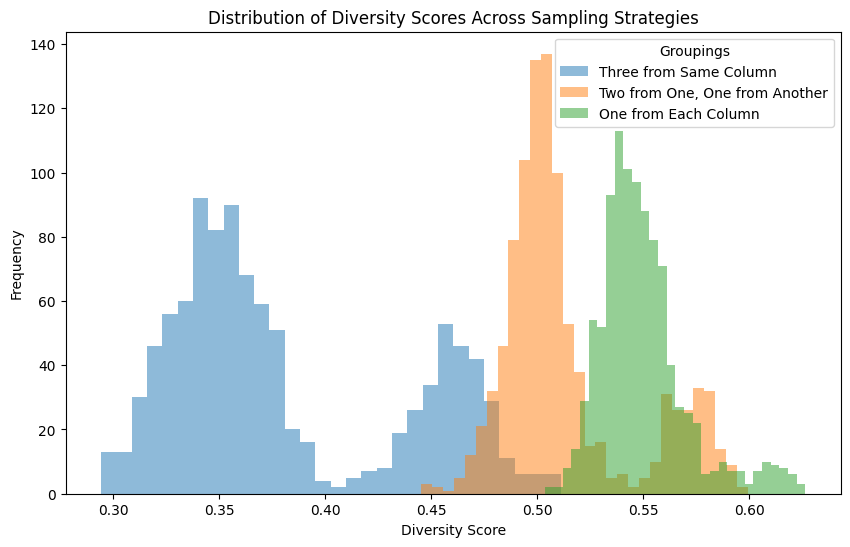

In [ ]:
# Required Imports
import numpy as np
import pandas as pd
from scipy.stats import entropy
import random
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load the Sentence Transformer model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Load the CSV file
df = pd.read_csv("sample_data/Flute_Claims_Expressions.csv")

# Convert columns to lists
anne_expressions = df["Anne (Utilitarian)"].tolist()
bob_expressions = df["Bob (Egalitarian)"].tolist()
carla_expressions = df["Carla (Libertarian)"].tolist()

# Function to generate embeddings
def generate_embeddings(texts):
    embeddings = model.encode(texts)
    embeddings = np.maximum(embeddings, 0)  # Ensure non-negativity
    row_sums = embeddings.sum(axis=1, keepdims=True)
    return np.divide(embeddings, row_sums, out=np.zeros_like(embeddings), where=row_sums != 0)

# Prepare diversity groups
diversity_scores = {
    "Three from Same Column": [],
    "Two from One, One from Another": [],
    "One from Each Column": []
}

# Number of trials
n_trials = 1000

# Perform trials
for _ in range(n_trials):
    # Group 1: Three from the same column
    group1 = random.sample(anne_expressions, 3)  # Choose Anne's column as example
    embeddings1 = generate_embeddings(group1)
    diversity_scores["Three from Same Column"].append(diversity(embeddings1))

    # Group 2: Two from one column, one from another
    group2 = random.sample(anne_expressions, 2) + random.sample(bob_expressions, 1)
    embeddings2 = generate_embeddings(group2)
    diversity_scores["Two from One, One from Another"].append(diversity(embeddings2))

    # Group 3: One from each column
    group3 = [
        random.choice(anne_expressions),
        random.choice(bob_expressions),
        random.choice(carla_expressions)
    ]
    embeddings3 = generate_embeddings(group3)
    diversity_scores["One from Each Column"].append(diversity(embeddings3))

# Plot distributions of diversity scores
plt.figure(figsize=(10, 6))
for label, scores in diversity_scores.items():
    plt.hist(scores, bins=30, alpha=0.5, label=label)
plt.xlabel("Diversity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Diversity Scores Across Sampling Strategies")
plt.legend(title="Groupings")
plt.show()


## Step 4: Testing Diversity Across Sampling Strategies

### Comparing Diversity Across Sampling Groups

We compare the diversity of arguments across three types of sampling strategies:
1. **Group 1:** Three arguments sampled from the same column (e.g., all from Anne's perspective).
2. **Group 2:** Two arguments from one column and one from another (e.g., two from Anne, one from Bob).
3. **Group 3:** One argument sampled from each column (Anne, Bob, Carla).

Each sampling strategy is repeated 1000 times, and the diversity scores are calculated for each trial. The resulting distributions are visualized to highlight the differences in semantic diversity.


# **Groupings**

Here are all the possible groupings of three samples:


1.   **AAA:** All three from Anne's column.
2.   **BBB:** All three from Bob's column.
3.   **CCC:** All three from Carla's column.
4.   **AAB:** Two from Anne, one from Bob.
5.   **AAC:** Two from Anne, one from Carla.
6.  **ABB:** Two from Bob, one from Anne.
7.  **BBC:** Two from Bob, one from Carla.
8.  **CCA:** Two from Carla, one from Anne.
9.  **CCB:** Two from Carla, one from Bob.
10. **ABC:** One from each column.


These represent all the possible groupings for sampling three responses, without considering order.



## Step 5: Visualizing Configurations

### Full Sampling Configurations

We further extend the analysis by exploring all possible configurations for sampling three arguments. This includes combinations like:
- **AAA:** Three from Anne’s column.
- **AAB:** Two from Anne, one from Bob.
- **ABC:** One from each column (Anne, Bob, Carla).
- **...and so on.**

For each configuration, we calculate diversity scores across multiple trials and plot their distributions. This analysis demonstrates how diversity increases as arguments from different perspectives are included.


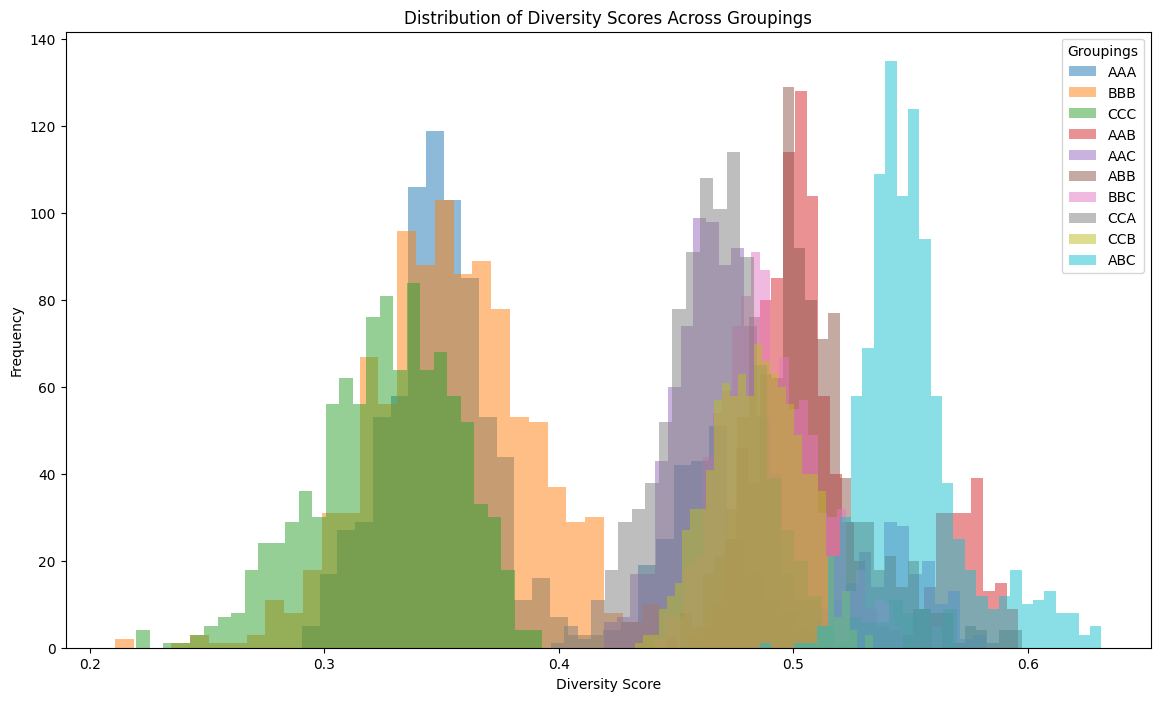

In [ ]:
# Prepare diversity groups for all configurations
diversity_scores = {
    "AAA": [],  # Three from Anne
    "BBB": [],  # Three from Bob
    "CCC": [],  # Three from Carla
    "AAB": [],  # Two from Anne, one from Bob
    "AAC": [],  # Two from Anne, one from Carla
    "ABB": [],  # Two from Bob, one from Anne
    "BBC": [],  # Two from Bob, one from Carla
    "CCA": [],  # Two from Carla, one from Anne
    "CCB": [],  # Two from Carla, one from Bob
    "ABC": []   # One from each column
}

# Number of trials
n_trials = 1000

# Perform trials for each grouping
for _ in range(n_trials):
    # AAA: Three from Anne
    group_aaa = random.sample(anne_expressions, 3)
    embeddings_aaa = generate_embeddings(group_aaa)
    diversity_scores["AAA"].append(diversity(embeddings_aaa))

    # BBB: Three from Bob
    group_bbb = random.sample(bob_expressions, 3)
    embeddings_bbb = generate_embeddings(group_bbb)
    diversity_scores["BBB"].append(diversity(embeddings_bbb))

    # CCC: Three from Carla
    group_ccc = random.sample(carla_expressions, 3)
    embeddings_ccc = generate_embeddings(group_ccc)
    diversity_scores["CCC"].append(diversity(embeddings_ccc))

    # AAB: Two from Anne, one from Bob
    group_aab = random.sample(anne_expressions, 2) + random.sample(bob_expressions, 1)
    embeddings_aab = generate_embeddings(group_aab)
    diversity_scores["AAB"].append(diversity(embeddings_aab))

    # AAC: Two from Anne, one from Carla
    group_aac = random.sample(anne_expressions, 2) + random.sample(carla_expressions, 1)
    embeddings_aac = generate_embeddings(group_aac)
    diversity_scores["AAC"].append(diversity(embeddings_aac))

    # ABB: Two from Bob, one from Anne
    group_abb = random.sample(bob_expressions, 2) + random.sample(anne_expressions, 1)
    embeddings_abb = generate_embeddings(group_abb)
    diversity_scores["ABB"].append(diversity(embeddings_abb))

    # BBC: Two from Bob, one from Carla
    group_bbc = random.sample(bob_expressions, 2) + random.sample(carla_expressions, 1)
    embeddings_bbc = generate_embeddings(group_bbc)
    diversity_scores["BBC"].append(diversity(embeddings_bbc))

    # CCA: Two from Carla, one from Anne
    group_cca = random.sample(carla_expressions, 2) + random.sample(anne_expressions, 1)
    embeddings_cca = generate_embeddings(group_cca)
    diversity_scores["CCA"].append(diversity(embeddings_cca))

    # CCB: Two from Carla, one from Bob
    group_ccb = random.sample(carla_expressions, 2) + random.sample(bob_expressions, 1)
    embeddings_ccb = generate_embeddings(group_ccb)
    diversity_scores["CCB"].append(diversity(embeddings_ccb))

    # ABC: One from each column
    group_abc = [
        random.choice(anne_expressions),
        random.choice(bob_expressions),
        random.choice(carla_expressions)
    ]
    embeddings_abc = generate_embeddings(group_abc)
    diversity_scores["ABC"].append(diversity(embeddings_abc))

# Plot the distributions of diversity scores for all configurations
plt.figure(figsize=(14, 8))
for key, scores in diversity_scores.items():
    plt.hist(scores, bins=30, alpha=0.5, label=key)

plt.xlabel("Diversity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Diversity Scores Across Groupings")
plt.legend(title="Groupings")
plt.show()


## Key Insights

### Key Findings

1. **Same Column Sampling:** Diversity scores are lowest when all three arguments come from a single column (e.g., AAA, BBB).
2. **Mixed Sampling:** Diversity scores increase when arguments are mixed across two perspectives (e.g., AAB, BBC).
3. **All Perspectives:** The highest diversity scores are observed when arguments are sampled from all three columns (ABC).

These findings align with our intuition: including multiple philosophical perspectives increases the semantic diversity of the sampled arguments.


## Conclusion

### Implications

This analysis demonstrates how a semantic diversity metric can quantify differences in textual arguments, enabling a nuanced comparison of perspectives. The techniques explored here could be applied to broader areas such as debate analysis, argumentation studies, or social media discussions.


# Appendix on the Transformations of Embeddings

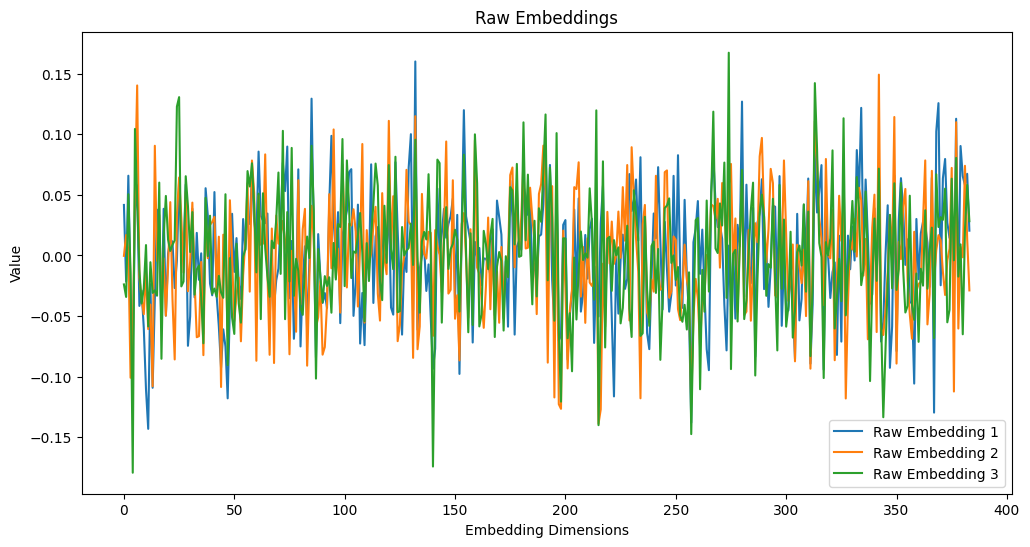

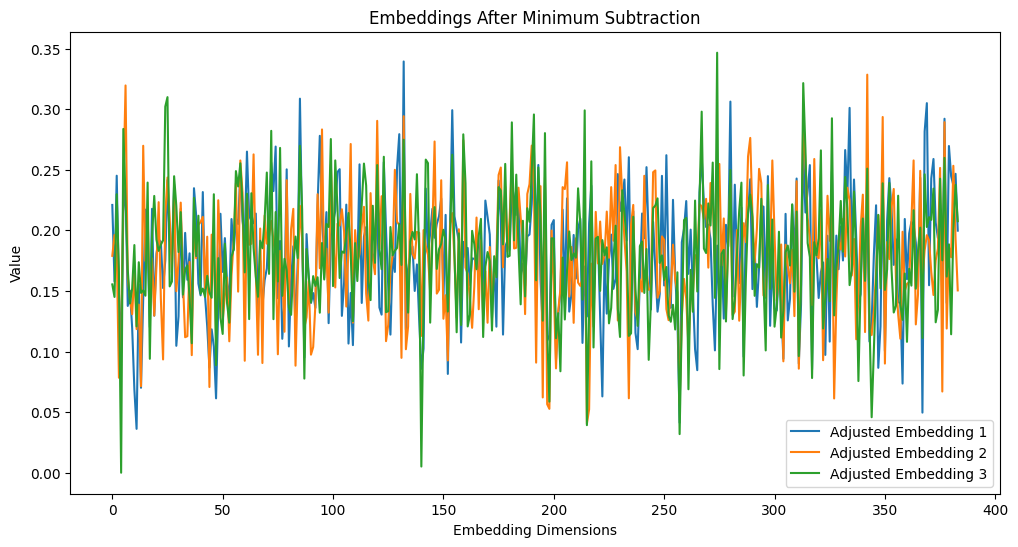

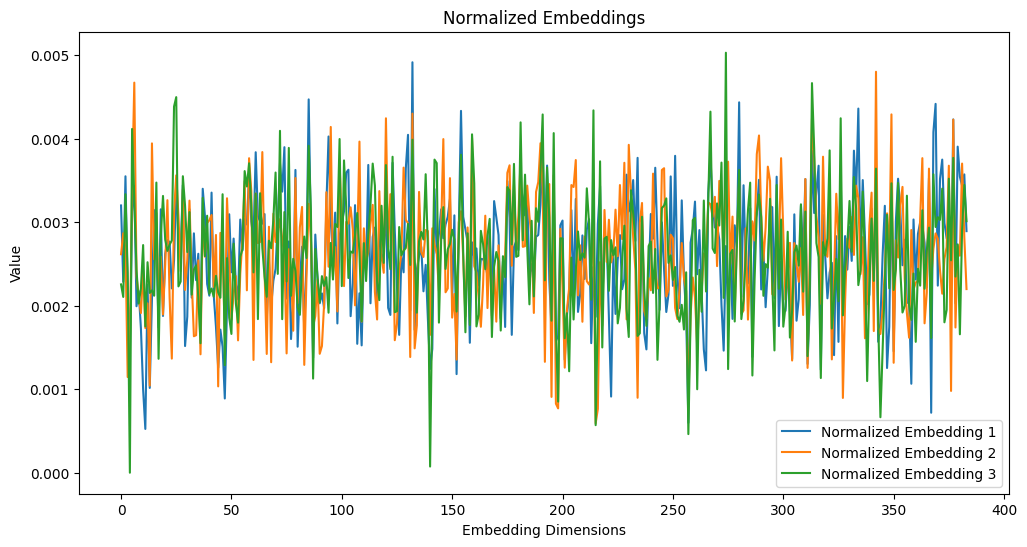

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Step 1: Define the sentences and generate embeddings
sentences = [
    "Anne is the only one who can create beautiful sounds with the flute.",
    "The flute is Bob’s chance to have something of his own to cherish.",
    "The flute is Carla’s property since she spent months making it."
]

# Load the Sentence Transformer model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Generate embeddings
embeddings = model.encode(sentences)

# Step 2: Visualize the raw embeddings
plt.figure(figsize=(12, 6))
for i, embedding in enumerate(embeddings):
    plt.plot(embedding, label=f"Raw Embedding {i+1}")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Value")
plt.title("Raw Embeddings")
plt.legend()
plt.show()

# Step 3: Subtract the global minimum to ensure non-negativity
global_min = np.min(embeddings)
adjusted_embeddings = embeddings - global_min

# Visualize the embeddings after global minimum subtraction
plt.figure(figsize=(12, 6))
for i, embedding in enumerate(adjusted_embeddings):
    plt.plot(embedding, label=f"Adjusted Embedding {i+1}")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Value")
plt.title("Embeddings After Minimum Subtraction")
plt.legend()
plt.show()

# Step 4: Normalize each embedding
row_sums = adjusted_embeddings.sum(axis=1, keepdims=True)
normalized_embeddings = np.divide(
    adjusted_embeddings,
    row_sums,
    out=np.zeros_like(adjusted_embeddings),
    where=row_sums != 0
)

# Visualize the normalized embeddings
plt.figure(figsize=(12, 6))
for i, embedding in enumerate(normalized_embeddings):
    plt.plot(embedding, label=f"Normalized Embedding {i+1}")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Value")
plt.title("Normalized Embeddings")
plt.legend()
plt.show()


### **Notes on Shape Preservation and Value Range Adjustment**

1. **Shape Preservation**:
   - The **shape of the data** remains unchanged throughout all transformations.
   - For example, if the embeddings have a shape of `(3, embedding_dimension)` initially, this shape is preserved after:
     - Subtracting the global minimum.
     - Normalizing the embeddings to sum to 1.
   - This ensures that the structural integrity of the embeddings is maintained, and transformations only affect the **value range**.

2. **Value Range Adjustment**:
   - **Raw Embeddings**: Contain both positive and negative values as generated by the model.
   - **Adjusted Embeddings**: All values are shifted to be non-negative by subtracting the **global minimum** (smallest value across all embeddings).
   - **Normalized Embeddings**: Values are scaled so that each embedding sums to 1, turning them into valid **probability distributions** suitable for computing diversity metrics.

By preserving the shape and only adjusting the value range, the embeddings retain their semantic structure while being transformed into a format that can be processed by the diversity metric.


In [ ]:
normalized_embeddings[0].shape  # note that the openAI embeddings are significantly larger which means that they have significantly more resolution, in terms of semantic differenciation.
                                # the disadvantage is that OpenAI isn't open source nor free.  These 384 dimensional embeddings (a factor of ten smaller than the OpenAI embeddings) are not open source but they're free.
                                # With a 3000+ dimensional embedding, which is what we have with openAI embeddings one can of course express a much richer semantic space.

(384,)